In [2]:
#Libraries
import cv2
import mediapipe as mp
import util
from pynput.mouse import Button, Controller
import pyautogui

In [3]:
mouse = Controller()

In [4]:
screen_width, screen_height = pyautogui.size()

In [5]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.7,
    min_tracking_confidence=0.7,
    max_num_hands=1
)

In [6]:
def find_finger_tip(processed):
    if processed.multi_hand_landmarks:
        hand_landmarks = processed.multi_hand_landmarks[0]  # Assuming only one hand is detected
        index_finger_tip = hand_landmarks.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP]
        return index_finger_tip
    return None

In [7]:
def move_mouse(index_finger_tip):
    if index_finger_tip is not None:
        x = int(index_finger_tip.x * screen_width)
        y = int(index_finger_tip.y / 2 * screen_height)
        pyautogui.moveTo(x, y)

In [8]:
def is_left_click(landmark_list, thumb_index_dist):
    return (
            util.get_angle(landmark_list[5], landmark_list[6], landmark_list[8]) < 50 and
            util.get_angle(landmark_list[9], landmark_list[10], landmark_list[12]) > 90 and
            thumb_index_dist > 50
    )

In [9]:
def is_right_click(landmark_list, thumb_index_dist):
    return (
            util.get_angle(landmark_list[9], landmark_list[10], landmark_list[12]) < 50 and
            util.get_angle(landmark_list[5], landmark_list[6], landmark_list[8]) > 90  and
            thumb_index_dist > 50
    )

In [10]:
def is_double_click(landmark_list, thumb_index_dist):
    return (
            util.get_angle(landmark_list[5], landmark_list[6], landmark_list[8]) < 50 and
            util.get_angle(landmark_list[9], landmark_list[10], landmark_list[12]) < 50 and
            thumb_index_dist > 50
    )

In [11]:
def detect_gesture(frame, landmark_list, processed):
    # Check if there are enough landmarks detected
    if len(landmark_list) >= 21:

        # Find the tip of the index finger
        index_finger_tip = find_finger_tip(processed)
        
        # Calculate the distance between thumb and index finger
        thumb_index_dist = util.get_distance([landmark_list[4], landmark_list[5]])

        # Check if the thumb and index finger are close, and the angle suggests a gesture for moving the mouse
        if util.get_distance([landmark_list[4], landmark_list[5]]) < 50 and util.get_angle(landmark_list[5], landmark_list[6], landmark_list[8]) > 90:
            # Move the mouse to the location of the index finger tip
            move_mouse(index_finger_tip)
        
        # Check if the gesture indicates a left click
        elif is_left_click(landmark_list, thumb_index_dist):
            # Perform a left click action
            mouse.press(Button.left)
            mouse.release(Button.left)
            cv2.putText(frame, "Left Click", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Check if the gesture indicates a right click
        elif is_right_click(landmark_list, thumb_index_dist):
            # Perform a right click action
            mouse.press(Button.right)
            mouse.release(Button.right)
            cv2.putText(frame, "Right Click", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        # Check if the gesture indicates a double click
        elif is_double_click(landmark_list, thumb_index_dist):
            # Perform a double click action
            pyautogui.doubleClick()
            cv2.putText(frame, "Double Click", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)


# HAND LANDMARKS

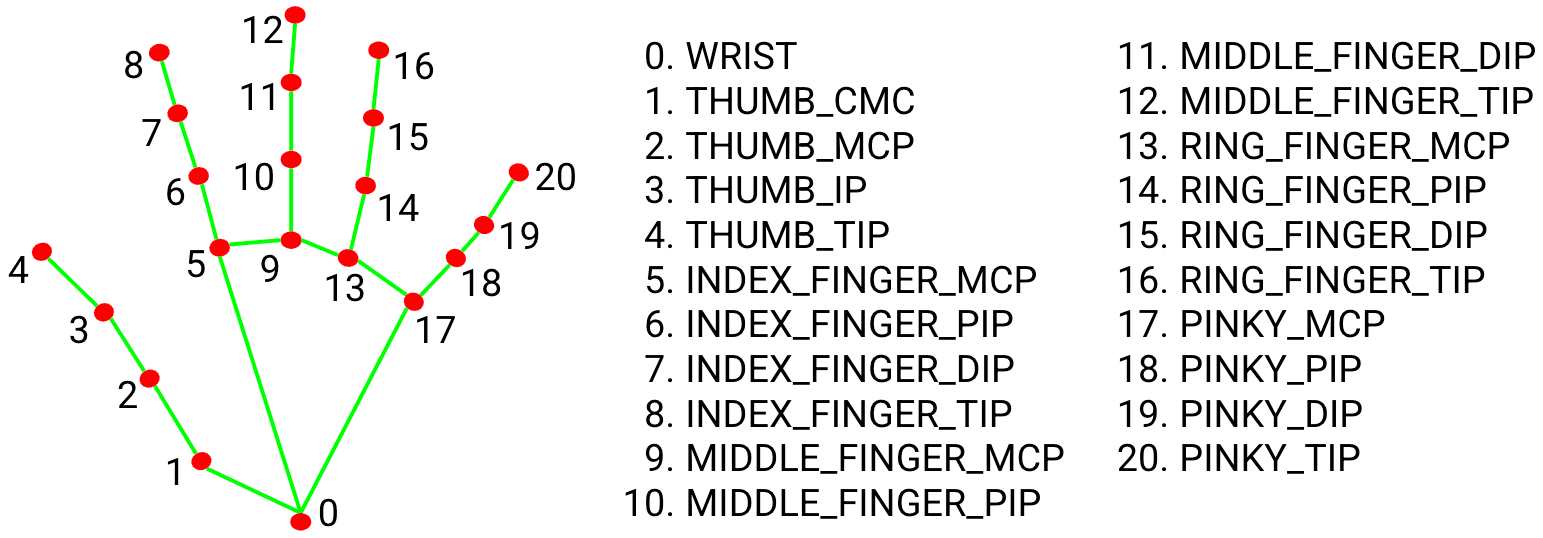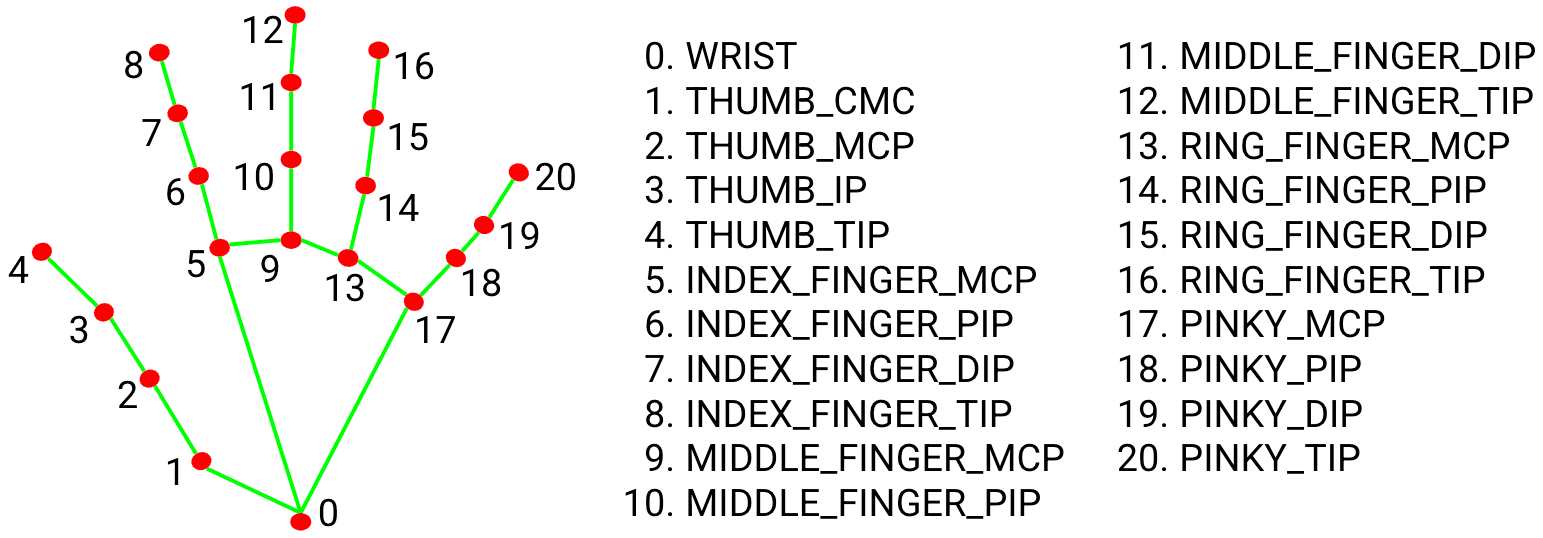

In [12]:
import cv2
import mediapipe as mp

def main():
    draw = mp.solutions.drawing_utils  # Utility for drawing landmarks
    cap = cv2.VideoCapture(0)  # Open the default camera

    try:
        while cap.isOpened():  # Check if the camera is opened
            ret, frame = cap.read()  # Read a frame from the camera
            if not ret:
                break  # Exit the loop if the frame is not captured
            
            frame = cv2.flip(frame, 1)  # Flip the frame horizontally for a mirror effect
            frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to RGB format
            processed = hands.process(frameRGB)  # Process the frame with MediaPipe Hands
            
            landmark_list = []  # List to store hand landmarks
            if processed.multi_hand_landmarks:
                hand_landmarks = processed.multi_hand_landmarks[0]  # Assuming only one hand is detected
                draw.draw_landmarks(frame, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)  # Draw landmarks on the frame
                
                for lm in hand_landmarks.landmark:
                    landmark_list.append((lm.x, lm.y))  # Store normalized landmark coordinates
            
            detect_gesture(frame, landmark_list, processed)  # Call gesture detection function
            
            cv2.imshow('VirtualMouse', frame)  # Display the frame
            if cv2.waitKey(1) & 0xFF == ord('q'):  # Exit loop when 'q' is pressed
                break
    
    finally:
        cap.release()  # Release the camera
        cv2.destroyAllWindows()  # Close all OpenCV windows

if __name__ == '__main__':
    main()  # Run the main function